# 필요한 패키지 임포트

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print('complete')

complete


# 데이터 수집하기

송영숙님이 공개한 챗봇 데이터 사용

In [2]:
path_chatbotdata = os.getenv('HOME') +'/aiffel/transformer_chatbot/data/ChatbotData .csv'
df = pd.read_csv(path_chatbotdata)

In [3]:
print(df.isnull().sum()) # 결측치 확인

Q        0
A        0
label    0
dtype: int64


In [4]:
df.head() # 데이터 확인

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
df.tail() # 데이터 확인

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


# 데이터 전처리하기

In [6]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = df.shape[0]
print(MAX_SAMPLES)

11823


### 전처리 함수 구현

정규표현식을 사용하여 구두점을 제거해, 단어를 토크나이징 하는 일에 방해되지 않도록 정제하는 함수 구현

In [7]:
# 전처리 함수
def preprocess_sentence(sentence):
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (ㄱ~ㅎ, ㅏ~ㅣ,가~힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ ㄱ-ㅣ가-힣!,.?]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print('complete')

complete


본문의 로드데이터 함수가 고쳐도 고쳐도 오류가 나길래, 그냥 구글링을 통해 직접 코드를 입력해 questions와 answers에 저장해주었다.

In [8]:
df['p_Q'] = df['Q'].map(lambda x : preprocess_sentence(x))
df['p_A'] = df['A'].map(lambda x : preprocess_sentence(x))

In [9]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
#questions, answers = load_conversations()
print('전체 샘플 수 :', len(df['p_Q']))
print('전체 샘플 수 :', len(df['p_A']))
print('전처리 후의 22번째 질문 샘플: {}'.format(df['p_Q'][21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(df['p_A'][21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [10]:
questions = df['p_Q']
answers = df['p_A']

### 로드한 데이터 샘플 확인

구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있다.

# SubwordTextEncoder 사용하기

단어보다 더 작은 단위인 subword를 기준으로 토크나이징하고 각 토큰을 고유한 정수로 인코딩   
각 문장을 토큰화하고 START_TOKEN 및 END_TOKEN 추가   
MAX_LENGTH를 넘는 문장은 필터링   
MAX_LENGTH보다 짧은 문장은 MAX_LENGTH 길이에 맞게 패딩

### 단어장 만들기

In [11]:
import tensorflow_datasets as tfds
print('processing...')

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print('complete')

processing...
complete


In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('complete')

complete


In [13]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8329]
END_TOKEN의 번호 : [8330]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8331


### 각 단어를 고유한 정수로 인코딩 & 패딩

In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5819, 609, 2499, 4169]
정수 인코딩 후의 21번째 답변 샘플: [2686, 7646, 8, 6357, 96, 1]


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs
print('complete')

complete


길이가 20을 넘는 경우를 필터링 했으므로, 단어장 크기와 샘플의 개수를 다시 확인한다.

In [18]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8331
필터링 후의 질문 샘플 개수: 11791
필터링 후의 답변 샘플 개수: 11791


### 교사 강요 사용하기

자기회귀 모델에서 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다. 이는 훈련 과정에서 훈련 속도가 지나치게 느려지는 결과를 초래하므로 (자기회귀 모델인)트랜스포머 디코더에 쿄사 강요를 적용한다.

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print('complete')

complete


# 모델 구성하기

### 포지셔널 인코딩 레이어

In [20]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print('complete')

complete


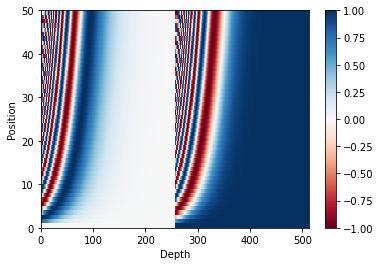

In [21]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 스케일드 닷 프로덕트 어텐션 함수 구현

어텐션은 안어들 간의 유사도를 구하는 메커니즘   
1.어텐션 함수는 주어진 쿼리(auery)에 대해서 모든 키(key)와의 유사도를 각각 구한다.   
2.구해낸 유사도를 키와 맵핑된 값(value)에 반영한다.   
3.유사도가 반영된 값을 모두 더해서 뭉치면 이를 최정 결과인 어텐션 값(Attention Value)라고 한다.   
   
1.Q, K, V는 단어벡터를 행으로 하는 문장 행렬   
2.벡터의 내적(dot product)은 벡터의 유사도를 의미   
3.특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링을 위함   
   
내적을 통해 벡터 간 유사도를 구한 후에 특정 값을 분모로 나눠주는 방식으로, Q와 K의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션이라고 한다.

In [22]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print('complete')

complete


### 멀티 헤드 어텐션 함수 구현

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
            query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
            batch_size = tf.shape(query)[0]

            # Q, K, V에 각각 Dense를 적용합니다
            query = self.query_dense(query)
            key = self.key_dense(key)
            value = self.value_dense(value)

            # 병렬 연산을 위한 머리를 여러 개 만듭니다
            query = self.split_heads(query, batch_size)
            key = self.split_heads(key, batch_size)
            value = self.split_heads(value, batch_size)

            # 스케일드 닷 프로덕트 어텐션 함수
            scaled_attention = scaled_dot_product_attention(query, key, value, mask)

            scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
           
            # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
            concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

            # 최종 결과에도 Dense를 한 번 더 적용합니다
            outputs = self.dense(concat_attention)

            return outputs
print('complete')

complete


### 패딩 마스킹(Padding Masking) 함수 구현

In [24]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print('complete')

complete


### 룩 어헤드 마스킹(Look-ahead Masking) 함수 구현

In [25]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print('complete')

complete


### 트랜스포머의 인코더 설계

하나의 인코더 층은 크게 총 2개의 sublayer로 나누어진다.   
셀프 어텐션(멀티 헤드 어텐션으로, 병렬적)   
피드 포워드 신경망   

In [26]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print('complete')

complete


### 인코더 층을 쌓아 인코더 만들기

구현한 인코더 층에 Embedding layer와 Positional Encoding을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

In [27]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
      )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print('complete')

complete


### 트랜스포머의 디코더 설계

디코더는 세 개의 sublayer로 구성된다.   
셀프 어텐션   
인코더-디코더 어텐션(셀프 어텐션과 달리 Query가 디코더의 벡터인 반면 Key와 Value가 인코더의 벡터다)   
피드 포워드 신경망   
디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티헤드 어텐션으로 병렬 수행한다.

In [28]:
# 디코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print('complete')

complete


### 디코더 층을 쌓아 디코더 만들기

구현한 디코더 층에 Embedding layer와 Positional Encoding을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
      )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print('complete')

complete


함수로 구현한 인코더 층과 디코더 층을 하나로 조합하여 트랜스포머 모델을 만들 수 있다.

### 모델 정의 및 학습하기

인코더 층 함수와 디코더 층 함수를 사용해 트랜스포머 함수를 정의한다.

In [30]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print('complete')

complete


### 모델 생성

In [31]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3186944     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수

레이블인 시퀀스에 패딩이 되어 있으므로, loss 계산 시 패딩 마스크를 적용해야 한다.

In [32]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print('complete')

complete


### 커스텀된 학습률

모델학습 초기에 learning rate를 급격히 높였다가, train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 커스텀 학습률 스케줄링(Custom Learning rate Scheduling) 사용

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print('complete')

complete


### 모델 컴파일

손실 함수와 커스텀된 학습률을 사용하여 모델 컴파일

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print('complete')

complete


### 훈련하기

In [35]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 13s 38ms/step - loss: 2.9787 - accuracy: 0.0661
Epoch 2/20
185/185 [==============================] - 7s 37ms/step - loss: 2.4201 - accuracy: 0.1016
Epoch 3/20
185/185 [==============================] - 7s 38ms/step - loss: 2.0538 - accuracy: 0.1036
Epoch 4/20
185/185 [==============================] - 7s 38ms/step - loss: 1.8956 - accuracy: 0.1110
Epoch 5/20
185/185 [==============================] - 7s 38ms/step - loss: 1.7769 - accuracy: 0.1180
Epoch 6/20
185/185 [==============================] - 7s 37ms/step - loss: 1.6553 - accuracy: 0.1265
Epoch 7/20
185/185 [==============================] - 7s 37ms/step - loss: 1.5206 - accuracy: 0.1382
Epoch 8/20
185/185 [==============================] - 7s 38ms/step - loss: 1.3727 - accuracy: 0.1545
Epoch 9/20
185/185 [==============================] - 7s 37ms/step - loss: 1.2121 - accuracy: 0.1720
Epoch 10/20
185/185 [==============================] - 7s 38ms/step - loss: 1.0462 - accur

# 모델 평가하기

### decoder_inference()함수 구현

1.새로운 입력 문장에 대해 훈련 때와 동일한 전처리   
2.입력 문장을 토크나이징, START_TOKEN과 END_TOKEN으르 추가   
3.패딩 마스킹과 룩 어헤드 마스킹 계산   
4.디코더는 입력 시퀀스로부터 다음 단어 예측   
5.디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용   
6.END_TOKEN이 예측되거나 문장 최대 길이에 도달하면 디코더 동작 중지   
의 과정을 담은 decoder_inference() 함수 생성

In [36]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print('complete')

complete


### sentence_generation()함수 구현

임의의 입력 문장에 대해 decoder_inference()함수를 호출, 챗봇의 대답을 얻는 sentence_generation()함수 생성

In [37]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print('complete')

complete


# 챗봇 테스트하기

In [38]:
sentence_generation("이름이 뭐야?")

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [39]:
sentence_generation("지금 너무 졸려")

입력 : 지금 너무 졸려
출력 : 낮잠은  분만 자세요 .


'낮잠은  분만 자세요 .'

In [40]:
sentence_generation("사랑은 뭘까?")

입력 : 사랑은 뭘까?
출력 : 사랑은 한 없이 줘도 아깝지 않은거라고 생각해요 .


'사랑은 한 없이 줘도 아깝지 않은거라고 생각해요 .'

# 회고

이번 Exploration은 지난 화요일 결석을 했고, 지금까지 쳐다보지도 않았기 때문에 그야말로 “단단히 밀린 과제”였다.   
참고로 나에게 세상에서 하기 싫은 일 top2중 1위는 했던 일 세이브파일 날려서 또 하기, 2위는 밀린 일 하기이므로 이번 과제를 시작하기까지 정말 오랜 시간이 걸렸다.   
즉, 디지몬 극장판 3편을 보고 나서야 겨우 의자에 앉았다. 1999년, 당시 초등학교 4학년인데도 각종 코드를 구현해 디지털 세계를 구한 한솔이를 존경하는 마음으로…   
자리에 앉은 다음에도 너무 너무 너무 하기가 싫어서 마음으로 엉엉 울며 노드를 시작했는데, 생각외로 너무 너무 너무 재미있고 이해가 금방 돼서 시간 가는 줄 모르고 본문을 노션에 정리하고 코드를 옮겨 적었다.   
로드 데이터 함수가 어떻게 해도 오류가 나길래 그냥 직접 question과 answer 데이터를 집어넣은 것 빼곤 별 오류 없이 아주 수월하게 진행했고, 결과적으로 만족스러운 대답을 도출하는 챗봇이 만들어졌다.   
사실 재미있어서 이것 저것 코드를 더 만져볼까 했는데, 이미 괜찮은 결과를 얻고 나니 괜히 건드렸다가 돌이킬 수 없는 강을 건너는거 아닌가 싶어 제출 후에 해보려고 한다.   
RNN과 LSTM cs231n강의 풀잎 이후 이 노드를 보게 된 것이 순서상 많은 도움이 됐다. 결국 트랜스포머란 RNN의 진화형이기 때문에, 딱 어제 RNN을 공부하고 보니 빠른 1회독만으로 이해가 꽤 수월했다.   
이젠 전처리도 나름 익숙해져서 결측치 확인 등 본문에 없던 자잘한 부분도 괜히 추가해봤다.   
학습에 있어 그 기반에는 즐거움이 있어야겠구나 다시금 느낀 과제였다. 앞으로는 너무 너무 너무 하기 싫을 땐 초등학생 신분으로 디지털 세계를 구한 선택받은 아이들을 생각하며 정신 차리고, 언젠가 디지털 월드에 난파되었을 때를 대비해야 한다는 마음으로 몰입해야지. 막상 들여다봤더니 재미있더라~ 하는 이 경험 또한 두고두고 상기해야겠다.